# Speckle Size Analysis

In [1]:
import speckle
from speckle.inference.read_in_data import read_in_data
from speckle.inference.correlation_heatmap import get_correlation,dump_heatmap,display_correlation_heatmaps,mask_heatmap,plot_radius_distribution
from speckle.inference.calculating_tau import objective, avg_correlation_single_px, plot_correlation_vs_lagtime,fit_exponential_decay, reconstruct,avg_correlation,calculate_correlation_pixel
from speckle.inference.dedrift import dedrift_videos

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import numpy as np
from scipy.optimize import curve_fit
import math
from operator import itemgetter

In [3]:
def spatial_correlation(example_img, sp_shape,ROI):
    y_length=example_img.shape[0]
    x_length=example_img.shape[1]
    num_pixels=y_length*x_length
    spcorrelation_map = np.zeros((sp_shape,sp_shape))
    for dy in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
        for dx in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
            sum_numerator=0
            sum_denum_1=0
            sum_denum_2=0
            count=0
            for y in range(ROI[0],ROI[0]+ROI[2],1):
                for x in range(ROI[1],ROI[1]+ROI[3],1):
                    sum_numerator+=int(example_img[y][x])*int(example_img[y+dy][x+dx])
                    sum_denum_1+=int(example_img[y][x])
                    sum_denum_2+=int(example_img[y+dy][x+dx])
                    count+=1
            numerator=sum_numerator/count
            denum_1=sum_denum_1/count
            denum_2=sum_denum_2/count
            spcorrelation_map[dy+math.floor(sp_shape/2)][dx+math.floor(sp_shape/2)]=copy.deepcopy(numerator/(denum_1*denum_2)-1)
    normalization=spcorrelation_map[math.floor(sp_shape/2)][math.floor(sp_shape/2)]
    spcorrelation_map=spcorrelation_map/normalization
    return spcorrelation_map

In [4]:
def plot_spmap(spcorrelation_map):
    f, axs = plt.subplots(2,1,figsize=(8,12))
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.concatenate(radius).flat
    spcorrelation_map_flatten=np.concatenate(spcorrelation_map).flat
    axs[0].plot(radius_flatten,spcorrelation_map_flatten,'.')
    axs[0].set_xlim(0,10)
    axs[0].legend(['Correlation vs delta r'], fontsize=18)
    axs[0].set_xlabel("delta r [pixels]",fontsize=18)
    axs[0].set_ylabel("Correlation",fontsize=18)
    axs[0] = sns.heatmap(spcorrelation_map)
    plt.show

In [5]:
def calculate_speckle_size(spcorrelation_map,startidx,endidx,plotBoolean=True):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    radius_squared=radius_flatten*radius_flatten
    log_correlation=np.log(abs(spcorrelation_map_flatten))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective(x_line, a)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        return np.sqrt(-1/a)

def objective(x, a):
	return a * x

In [6]:
def reconstruct_curve(spcorrelation_map,a):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.concatenate(radius).flat
    spcorrelation_map_flatten=np.concatenate(spcorrelation_map).flat
    y=(np.exp(a*radius_flatten))
    plt.figure(figsize=(8,5))
    plt.plot(radius_flatten,y,'*',label="fit line")
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)

# 24 hour video (256*256 size) - FUS

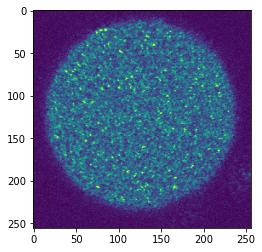

In [57]:
## Load in data
video_time_length=60 #s
video_frame_numbers=1129 #frames
imgname='1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator/'
framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

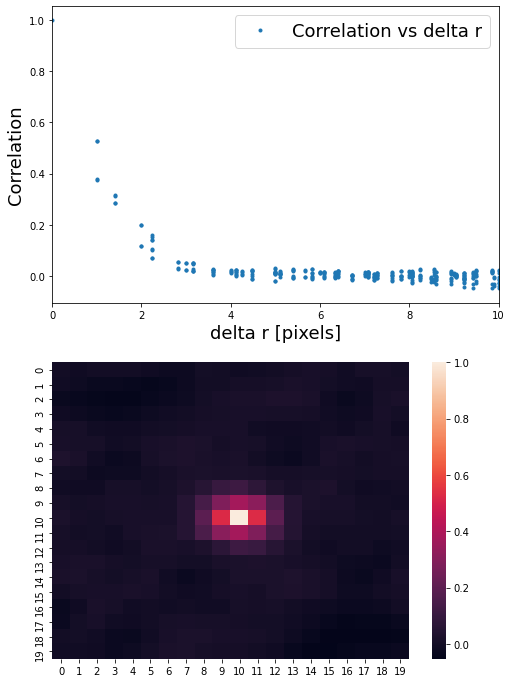

In [58]:
img_24h=img[20]
ROI=[80,70,100,110] #y,x,w,h
sp_shape=20
spmap_24h=spatial_correlation(img_24h,sp_shape,ROI)
plot_spmap(spmap_24h)

corresponds to speckle size $c_I(\delta_{r}) = exp(-\delta_{r}^2/\sigma^2)$

speckle size is: [1.112143]
y = -0.80850 * x


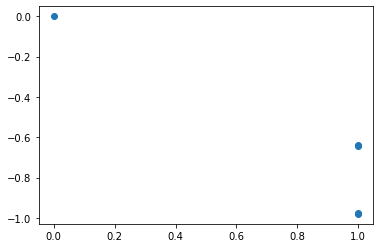

In [59]:
size_24h,a_24h =calculate_speckle_size(spmap_24h,0,5)

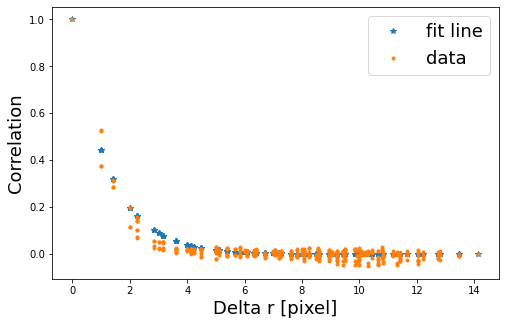

In [60]:
reconstruct_curve(spmap_24h,a_24h)

In [61]:
scale=9.775
speckle_size_24h=size_24h/scale
print('The size is :'+str(speckle_size_24h)+' um')

The size is :[0.11377422] um


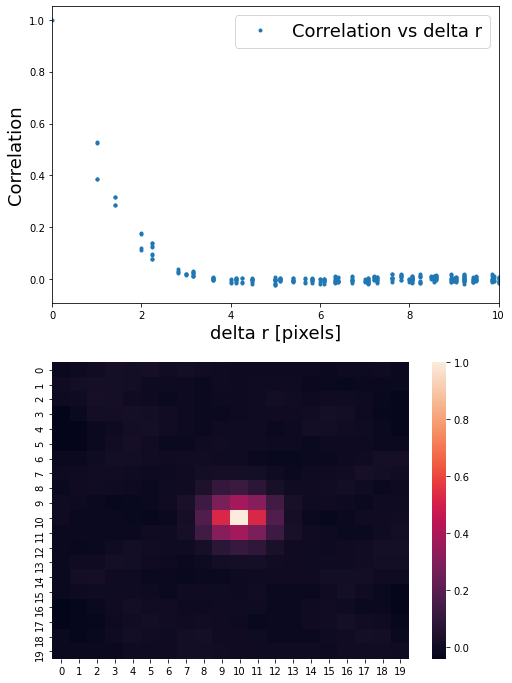

In [62]:
img_24h_900=img[900]
ROI=[80,70,100,110] #y,x,w,h
sp_shape=20
spmap_24h_900=spatial_correlation(img_24h_900,sp_shape,ROI)
plot_spmap(spmap_24h_900)

speckle size is: [1.20616646]
y = -0.68736 * x


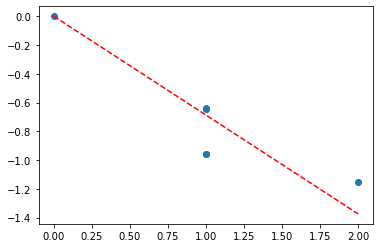

In [63]:
size_24h_900,a_24h_900=calculate_speckle_size(spmap_24h_900,0,6)

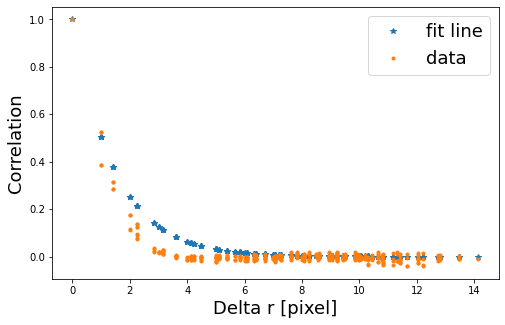

In [64]:
reconstruct_curve(spmap_24h_900,a_24h_900)

In [65]:
scale=9.775
speckle_size_24h_900=size_24h_900/scale
print('The size is :'+str(speckle_size_24h_900)+' um')

The size is :[0.12339299] um


# Fresh video(512*512) -FUS

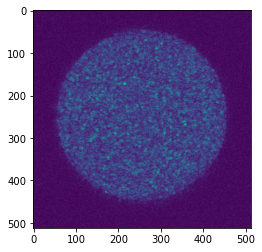

In [43]:
imgname='300f_405_1.0p_725gain_2min_1141frames_fresh'
foldername='/Users/wenyun/Desktop/research/Speckle project/Temp_data/405_1.0p_725gain_2min_1141frames_fresh/'
img=read_in_data(foldername,imgname)

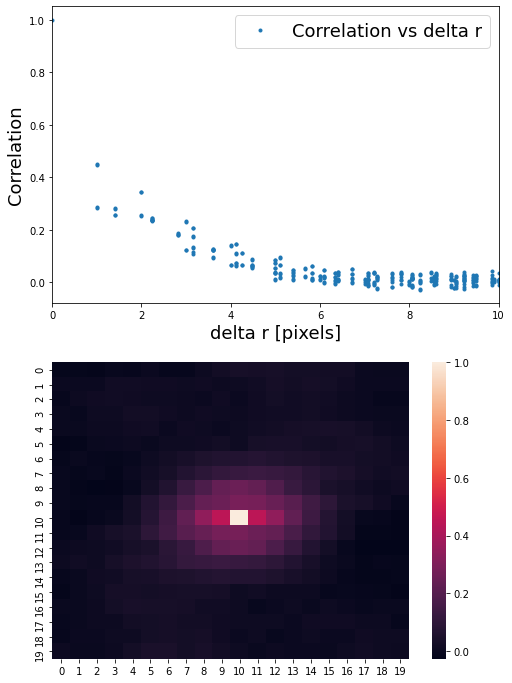

In [44]:
img_fresh_20=img[20]
ROI=[200,200,100,100] #y,x,w,h
sp_shape=20
spmap_fresh_20=spatial_correlation(img_fresh_20,sp_shape,ROI)
plot_spmap(spmap_fresh_20)

speckle size is: [1.11808651]
y = -0.79992 * x


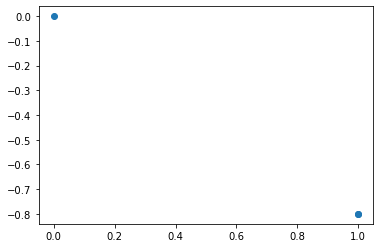

In [55]:
size_fresh,a_fresh=calculate_speckle_size(spmap_fresh_20,0,3)

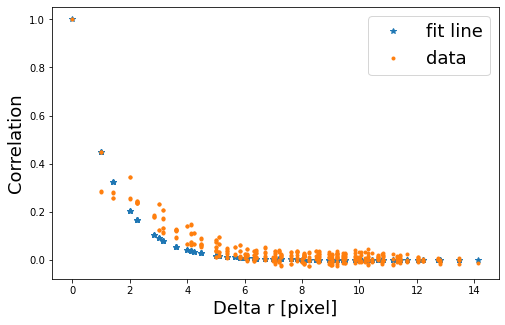

In [56]:
reconstruct_curve(spmap_fresh_20,a_fresh)

bidirectional scan not aligned well

# UVed

In [ ]:
imgname='405_1.0p_725gain_2min_1141frmaes_fresh_after_UV'
foldername='/Users/wenyun/Desktop/research/Speckle project/Temp_data/405_1.0p_725gain_2min_1141frmaes_fresh_after_UV/'
img=read_in_data(foldername,imgname)

In [ ]:
img_UV_20=img[20]
ROI=[200,200,100,100] #y,x,w,h
sp_shape=20
spmap_UV_20=spatial_correlation(img_UV_20,sp_shape,ROI)
plot_spmap(spmap_UV_20)

In [ ]:
size,a=calculate_speckle_size(spmap_UV_20,0,30)

In [ ]:
reconstruct_curve(spmap_UV_20,a)

# G3BP1

In [ ]:
imgname='speckle_GFP_G3BP1_405nm_9power_2haged_equator_30s'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/speckle_GFP_G3BP1_405nm_9power_2haged_equator_30s/'
img=read_in_data(foldername,imgname)

In [ ]:
img_G3BP1_20=img[20]
ROI=[100,80,80,80] #y,x,w,h
sp_shape=20
spmap_G3BP1_20=spatial_correlation(img_G3BP1_20,sp_shape,ROI)
plot_spmap(spmap_G3BP1_20)

In [ ]:
size,a=calculate_speckle_size(spmap_G3BP1_20,0,20)

In [ ]:
reconstruct_curve(spmap_G3BP1_20,a)